In [ ]:
pip install langchain==0.3.7 langchain-community==0.3.7 langchain_google_genai==2.0.4 duckduckgo_search==6.3.4 langgraph==0.2.48 python-dotenv langchain_groq

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START #Importing StateGraph, END, and START from langgraph.graph to define and manage state transitions within a conversational or generative AI workflow.
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod # to visualize the graph of langgraph node and edges
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

#llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
#                             verbose=True,
#                             temperature=0.5,
#                             google_api_key=GOOGLE_API_KEY)

In [3]:
import getpass
from kaggle_secrets import UserSecretsClient
import os

user_secrets = UserSecretsClient()
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")

os.environ["GROQ_API_KEY"]=GROQ_API_KEY

In [4]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ca0828e3dc0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ca0827211e0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
class State(TypedDict):
    query: str
    category: str
    response: str

In [6]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages

def trim_conversation(prompt):
    """Trims conversation history to retain only the latest messages within the limit."""
    max_messages = 10 
    return trim_messages(
        prompt,
        max_tokens=max_messages,
        strategy="last",
        token_counter=len, 
        start_on="human", 
        include_system=True, 
        allow_partial=False,
    )

import os
from datetime import datetime

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "Agent_output"  
    os.makedirs(folder_name, exist_ok=True) 

    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"{filename}_{timestamp}.md"
    file_path = os.path.join(folder_name, filename)
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")
    return file_path

def show_md_file(file_path):
    """Displays the content of a markdown file as Markdown in the notebook."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    display(Markdown(content))

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools import DuckDuckGoSearchResults #searching tools
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

class LearningResourceAgent:
    def __init__(self, prompt):
        self.model = ChatGroq(model="llama-3.3-70b-versatile")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def TutorialAgent(self, user_input):
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"input": user_input})
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path

    def QueryBot(self, user_input):
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.append('User Query: %s \n' % user_input)
        self.prompt.append(HumanMessage(content=user_input))
        while True:
            self.prompt = trim_conversation(self.prompt)
            response = self.model.invoke(self.prompt)
            record_QA_session.append('\nExpert Response: %s \n' % response.content)
            
            self.prompt.append(AIMessage(content=response.content))
            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\nEXPERT AGENT RESPONSE:", response.content)
            
            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\nYOUR QUERY: ")
            record_QA_session.append('\nUser Query: %s \n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))

            if user_input.lower() == "exit":
                print("Ending the chat session.")
                path = save_file(''.join(record_QA_session),'Q&A_Doubt_Session')
                print(f"Q&A Session saved to {path}")
                return path

In [8]:
class InterviewAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for use in the agent
        self.model = ChatGroq(model="llama-3.3-70b-versatile")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Web search tool for retrieving additional information

    def Interview_questions(self, user_input):
        # Holds the conversation history and cumulative questions and answers
        chat_history = []
        questions_bank = ''
        # Create an agent executor with tool access and enable verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to the user input and add it to questions_bank
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"
            
            # Update chat history with user input and AI response, limiting history to the last 10 messages
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]  # Keep only the last 10 messages
            
            # Get the next input from the user to continue the conversation
            user_input = input("You: ")
        
        # Save the entire question-response history to a markdown file and display it
        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interviews question saved to {path}")
        return path

    def Mock_Interview(self):
        # Start a simulated mock interview session
        print("\nStarting the mock interview. Type 'exit' to end the session.\n")
        
        # Initialize with a starting message and store interview records
        initial_message = 'I am ready for the interview.\n'
        interview_record = []
        interview_record.append('Candidate: %s \n' % initial_message)
        self.prompt.append(HumanMessage(content=initial_message))
        
        while True:
            # Trim conversation history if necessary to maintain prompt size
            self.prompt = trim_conversation(self.prompt)
            
            # Generate a response using the chat model
            response = self.model.invoke(self.prompt)
            
            # Add AI response to the conversation history
            self.prompt.append(AIMessage(content=response.content))
            
            # Output the AI's response as the "Interviewer"
            print("\nInterviewer:", response.content)
            interview_record.append('\nInterviewer: %s \n' % response.content)
            
            # Get the user's response as "Candidate" input
            user_input = input("\nCandidate: ")
            interview_record.append('\nCandidate: %s \n' % user_input)
            
            # Add user input to the conversation history
            self.prompt.append(HumanMessage(content=user_input))
            
            # End the interview if the user types "exit"
            if user_input.lower() == "exit":
                print("Ending the interview session.")
                path = save_file(''.join(interview_record),'Mock_Interview')
                print(f"Mock Interview saved to {path}")
                return path

In [9]:
class ResumeMaker:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for resume creation
        self.model = ChatGroq(model="llama-3.3-70b-versatile")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Search tool to gather additional information if needed
        # Create an agent executor with tool access, enabling verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        # Maintain chat history for the resume creation conversation
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to user input using the agent and add it to the chat history
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            
            # Limit the chat history to the last 10 messages
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            # Prompt for the next user input to continue the resume creation conversation
            user_input = input("You: ")
        
        # Save the final output as a markdown file and return the file path
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path

In [10]:
class JobSearch:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for job search assistance
        self.model = ChatGroq(model="llama-3.3-70b-versatile")
        self.prompt = prompt
        self.tools = DuckDuckGoSearchResults()  # Search tool to find job listings or related information
        # Create an agent executor with tool access, enabling verbose output and error handling
        # self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        # self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def find_jobs(self, user_input):
        results = self.tools.invoke(user_input)
        chain = self.prompt | self.model  
        jobs = chain.invoke({"result": results}).content
        
        path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
        print(f"Jobs saved to {path}")
        return path

In [11]:
def categorize(state: State) -> State:
    """Categorizes the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n"
        "4. Query: 'Are there any job openings for AI engineers?' -> 4\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )

    # Creates a categorization chain and invokes it with the user's query to get the category
    chain = prompt | llm 
    print('Categorizing the customer query...')
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def handle_learning_resource(state: State) -> State:
    """Determines if the query is related to Tutorial creation or general Questions on generative AI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Tutorial or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

def handle_interview_preparation(state: State) -> State:
    """Determines if the query is related to Mock Interviews or general Interview Questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Mock or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

In [12]:
def job_search(state: State) -> State:
    """Provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''Your task is to refactor and make .md file for the this content which includes
    the jobs available in the market. Refactor such that user can refer easily. Content: {result}''')
    jobSearch = JobSearch(prompt)
    state["query"] = input('Please make sure to mention Job location you want,Job roles\n')
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

def handle_resume_making(state: State) -> State:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''),
       MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response": path}

In [13]:
def ask_query_bot(state: State) -> State:
    """Provide detailed answers to user queries related to Generative AI."""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content=system_message)]

    learning_agent = LearningResourceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response": path}

def tutorial_agent(state: State) -> State:
    """Generate a tutorial blog for Generative AI based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    prompt = ChatPromptTemplate.from_messages([("system", system_message),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])
    #agent_scratchpad is a function that formats the intermediate steps of the agent's actions and observations into a string. 
    #This function is used to keep track of the agent's thoughts or actions during the execution of the program. But its not necessary, we can do without this so we will not include it only define it.
    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

In [14]:
def interview_topics_questions(state: State) -> State:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

def mock_interview(state: State) -> State:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

In [15]:
def route_query(state: State):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state["category"]:
        print('Category: handle_learning_resource')
        return "handle_learning_resource"  # Directs queries about learning generative AI to the learning resource handler
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"  # Directs queries about resume making to the resume handler
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"  # Directs queries about interview preparation to the interview handler
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search"  # Directs job search queries to the job search handler
    else:
        print("Please ask your question based on my description.")
        return False  # Returns False if the category does not match any predefined options

def route_interview(state: State) -> str:
    """Route the query to the appropriate interview-related handler."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"  # Directs to the handler for interview topic questions
    elif 'Mock'.lower() in state["category"].lower():
        print('Category: mock_interview')
        return "mock_interview"  # Directs to the mock interview handler
    else:
        print('Category: mock_interview')
        return "mock_interview"  # Defaults to mock interview if category does not clearly match

def route_learning(state: State):
    """Route the query based on the learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: ask_query_bot')
        return "ask_query_bot"  # Directs queries to the general question bot
    elif 'Tutorial'.lower() in state["category"].lower():
        print('Category: tutorial_agent')
        return "tutorial_agent"  # Directs queries to the tutorial creation agent
    else:
        print("Please ask your question based on my interview description.")
        return False  # Returns False if no clear category match is found

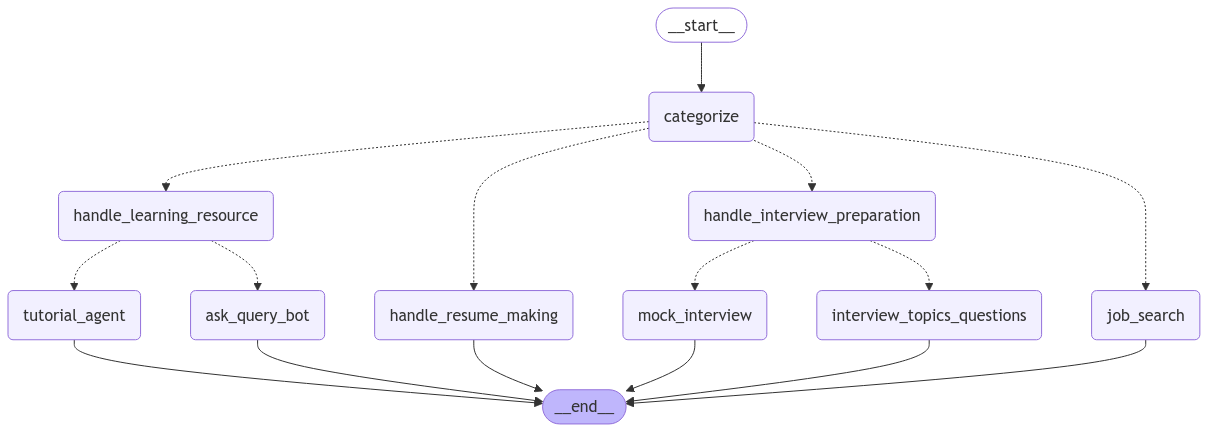

In [16]:
# Create the workflow graph
workflow = StateGraph(State)

# Add nodes for each state in the workflow
workflow.add_node("categorize", categorize)  # Initial categorization node
workflow.add_node("handle_learning_resource", handle_learning_resource)  # Handles learning-related queries
workflow.add_node("handle_resume_making", handle_resume_making)  # Handles resume-making queries
workflow.add_node("handle_interview_preparation", handle_interview_preparation)  # Handles interview prep queries
workflow.add_node("job_search", job_search)  # Handles job search queries
workflow.add_node("mock_interview", mock_interview)  # Handles mock interview sessions
workflow.add_node("interview_topics_questions", interview_topics_questions)  # Handles interview topic questions
workflow.add_node("tutorial_agent", tutorial_agent)  # Tutorial agent for generative AI learning resources
workflow.add_node("ask_query_bot", ask_query_bot)  # General query bot for learning resources

# Define the starting edge to the categorization node
workflow.add_edge(START, "categorize")

# Add conditional edges based on category routing function
workflow.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search"
    }
)

# Add conditional edges for further routing in interview preparation
workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,
    {
        "mock_interview": "mock_interview",
        "interview_topics_questions": "interview_topics_questions",
    }
)

# Add conditional edges for further routing in learning resources
workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,
    {
        "tutorial_agent": "tutorial_agent",
        "ask_query_bot": "ask_query_bot",
    }
)

# Define edges that lead to the end of the workflow
workflow.add_edge("handle_resume_making", END)
workflow.add_edge("job_search", END)
workflow.add_edge("interview_topics_questions", END)
workflow.add_edge("mock_interview", END)
workflow.add_edge("ask_query_bot", END)
workflow.add_edge("tutorial_agent", END)

# Set the initial entry point to start the workflow at the categorize node
workflow.set_entry_point("categorize")

# Compile the workflow graph into an application
app = workflow.compile()

# Display the workflow graph as a PNG image using Mermaid
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

In [17]:
def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "response": results["response"]
    }

In [18]:
query = "I want to learn Quantum computing Quantum machine learning. Also give coding example implementation for both.Create tutorial for this."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Quantum computing and quantum machine learning are fascinating fields that have the potential to revolutionize the way we approach complex problems. I'd be happy to help you get started.

**Introduction to Quantum Computing**

Quantum computing is a new paradigm for computing that uses the principles of quantum mechanics to perform calculations. Unlike classical computers, which use bits to represent information, quantum computers use qubits (quantum bits) that can exist in multiple states simultaneously. This allows quantum computers to process vast amounts of information in parallel, making them potentially much faster than classical computers for certain types o


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033501.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033501.md


User Query: I want to learn Quantum computing Quantum machine learning. Also give coding example implementation for both.Create tutorial for this. 

Expert Response: Quantum computing and quantum machine learning are fascinating fields that have the potential to revolutionize the way we approach complex problems. I'd be happy to help you get started.

**Introduction to Quantum Computing**

Quantum computing is a new paradigm for computing that uses the principles of quantum mechanics to perform calculations. Unlike classical computers, which use bits to represent information, quantum computers use qubits (quantum bits) that can exist in multiple states simultaneously. This allows quantum computers to process vast amounts of information in parallel, making them potentially much faster than classical computers for certain types of calculations.

**Introduction to Quantum Machine Learning**

Quantum machine learning is a subfield of quantum computing that focuses on developing algorithms and techniques for machine learning that can be run on quantum computers. Quantum machine learning has the potential to solve complex problems in areas such as image recognition, natural language processing, and predictive modeling.

**Coding Example: Quantum Computing with Qiskit**

To get started with quantum computing, let's use the Qiskit library, which is an open-source framework for quantum computing developed by IBM. Here's an example code snippet that demonstrates a simple quantum circuit:
```python
from qiskit import QuantumCircuit, execute

# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Apply a Hadamard gate to the first qubit
qc.h(0)

# Apply a controlled-NOT gate to the second qubit
qc.cx(0, 1)

# Measure the qubits
qc.measure([0, 1], [0, 1])

# Execute the circuit on a simulator
simulator = execute(qc, backend='qasm_simulator')
result = simulator.result()

# Print the results
print(result.get_counts())
```
This code creates a simple quantum circuit with 2 qubits and 2 classical bits, applies a Hadamard gate to the first qubit, and then applies a controlled-NOT gate to the second qubit. Finally, it measures the qubits and prints the results.

**Coding Example: Quantum Machine Learning with Qiskit**

To get started with quantum machine learning, let's use the Qiskit library to implement a simple quantum k-means clustering algorithm. Here's an example code snippet:
```python
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Statevector
import numpy as np

# Define the number of clusters and the number of data points
num_clusters = 2
num_data_points = 10

# Generate some random data points
data_points = np.random.rand(num_data_points, 2)

# Define the quantum circuit for the k-means algorithm
qc = QuantumCircuit(num_clusters, num_clusters)

# Apply a Hadamard gate to each qubit
for i in range(num_clusters):
    qc.h(i)

# Apply a controlled-NOT gate to each qubit
for i in range(num_clusters):
    for j in range(num_clusters):
        if i != j:
            qc.cx(i, j)

# Measure the qubits
qc.measure([i for i in range(num_clusters)], [i for i in range(num_clusters)])

# Execute the circuit on a simulator
simulator = execute(qc, backend='qasm_simulator')
result = simulator.result()

# Print the results
print(result.get_counts())

# Use the results to assign each data point to a cluster
cluster_assignments = []
for i in range(num_data_points):
    # Calculate the distance between the data point and each cluster center
    distances = []
    for j in range(num_clusters):
        distance = np.linalg.norm(data_points[i] - np.array([j, j]))
        distances.append(distance)
    # Assign the data point to the cluster with the closest center
    cluster_assignments.append(np.argmin(distances))

# Print the cluster assignments
print(cluster_assignments)
```
This code defines a simple quantum k-means clustering algorithm that uses a quantum circuit to assign each data point to a cluster. The algorithm applies a Hadamard gate to each qubit, followed by a controlled-NOT gate to each qubit. The results are then used to assign each data point to a cluster based on the closest cluster center.

**Tutorial**

Here is a step-by-step tutorial to get started with quantum computing and quantum machine learning:

1. **Install Qiskit**: Install the Qiskit library by running `pip install qiskit` in your terminal.
2. **Learn the basics of quantum computing**: Start by learning the basics of quantum computing, including qubits, quantum gates, and quantum circuits.
3. **Practice with Qiskit**: Practice using Qiskit by running simple quantum circuits and experimenting with different quantum gates and circuits.
4. **Learn quantum machine learning algorithms**: Learn about quantum machine learning algorithms, including k-means clustering, support vector machines, and neural networks.
5. **Implement quantum machine learning algorithms**: Implement quantum machine learning algorithms using Qiskit, starting with simple algorithms like k-means clustering.
6. **Experiment with different datasets**: Experiment with different datasets and evaluate the performance of quantum machine learning algorithms on these datasets.
7. **Stay up-to-date with the latest developments**: Stay up-to-date with the latest developments in quantum computing and quantum machine learning by attending conferences, reading research papers, and following online forums and blogs.

I hope this helps! Let me know if you have any questions or need further clarification on any of the concepts. 

What would you like to do next? Would you like to:

A) Learn more about quantum computing and quantum machine learning
B) Practice with Qiskit and implement quantum machine learning algorithms
C) Experiment with different datasets and evaluate the performance of quantum machine learning algorithms
D) Stay up-to-date with the latest developments in quantum computing and quantum machine learning

Please respond with the letter of your chosen action. 

User Query: Quantum computing and quantum machine learning are fascinating fields that have the potential to revolutionize the way we approach complex problems. I'd be happy to help you get started.

**Introduction to Quantum Computing**

Quantum computing is a new paradigm for computing that uses the principles of quantum mechanics to perform calculations. Unlike classical computers, which use bits to represent information, quantum computers use qubits (quantum bits) that can exist in multiple states simultaneously. This allows quantum computers to process vast amounts of information in parallel, making them potentially much faster than classical computers for certain types of calculations.

**Introduction to Quantum Machine Learning**

Quantum machine learning is a subfield of quantum computing that focuses on developing algorithms and techniques for machine learning that can be run on quantum computers. Quantum machine learning has the potential to solve complex problems in areas such as image recognition, natural language processing, and predictive modeling.

**Coding Example: Quantum Computing with Qiskit**

To get started with quantum computing, let's use the Qiskit library, which is an open-source framework for quantum computing developed by IBM. Here's an example code snippet that demonstrates a simple quantum circuit:
```python
from qiskit import QuantumCircuit, execute

# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Apply a Hadamard gate to the first qubit
qc.h(0)

# Apply a controlled-NOT gate to the second qubit
qc.cx(0, 1)

# Measure the qubits
qc.measure([0, 1], [0, 1])

# Execute the circuit on a simulator
simulator = execute(qc, backend='qasm_simulator')
result = simulator.result()

# Print the results
print(result.get_counts())
```
This code creates a simple quantum circuit with 2 qubits and 2 classical bits, applies a Hadamard gate to the first qubit, and then applies a controlled-NOT gate to the second qubit. Finally, it measures the qubits and prints the results.

**Coding Example: Quantum Machine Learning with Qiskit**

To get started with quantum machine learning, let's use the Qiskit library to implement a simple quantum k-means clustering algorithm. Here's an example code snippet:
```python
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Statevector
import numpy as np

# Define the number of clusters and the number of data points
num_clusters = 2
num_data_points = 10

# Generate some random data points
data_points = np.random.rand(num_data_points, 2)

# Define the quantum circuit for the k-means algorithm
qc = QuantumCircuit(num_clusters, num_clusters)

# Apply a Hadamard gate to each qubit
for i in range(num_clusters):
    qc.h(i)

# Apply a controlled-NOT gate to each qubit
for i in range(num_clusters):
    for j in range(num_clusters):
        if i != j:
            qc.cx(i, j)

# Measure the qubits
qc.measure([i for i in range(num_clusters)], [i for i in range(num_clusters)])

# Execute the circuit on a simulator
simulator = execute(qc, backend='qasm_simulator')
result = simulator.result()

# Print the results
print(result.get_counts())

# Use the results to assign each data point to a cluster
cluster_assignments = []
for i in range(num_data_points):
    # Calculate the distance between the data point and each cluster center
    distances = []
    for j in range(num_clusters):
        distance = np.linalg.norm(data_points[i] - np.array([j, j]))
        distances.append(distance)
    # Assign the data point to the cluster with the closest center
    cluster_assignments.append(np.argmin(distances))

# Print the cluster assignments
print(cluster_assignments)
```
This code defines a simple quantum k-means clustering algorithm that uses a quantum circuit to assign each data point to a cluster. The algorithm applies a Hadamard gate to each qubit, followed by a controlled-NOT gate to each qubit. The results are then used to assign each data point to a cluster based on the closest cluster center.

**Tutorial**

Here is a step-by-step tutorial to get started with quantum computing and quantum machine learning:

1. **Install Qiskit**: Install the Qiskit library by running `pip install qiskit` in your terminal.
2. **Learn the basics of quantum computing**: Start by learning the basics of quantum computing, including qubits, quantum gates, and quantum circuits.
3. **Practice with Qiskit**: Practice using Qiskit by running simple quantum circuits and experimenting with different quantum gates and circuits.
4. **Learn quantum machine learning algorithms**: Learn about quantum machine learning algorithms, including k-means clustering, support vector machines, and neural networks.
5. **Implement quantum machine learning algorithms**: Implement quantum machine learning algorithms using Qiskit, starting with simple algorithms like k-means clustering.
6. **Experiment with different datasets**: Experiment with different datasets and evaluate the performance of quantum machine learning algorithms on these datasets.
7. **Stay up-to-date with the latest developments**: Stay up-to-date with the latest developments in quantum computing and quantum machine learning by attending conferences, reading research papers, and following online forums and blogs.

I hope this helps! Let me know if you have any questions or need further clarification on any of the concepts. 

What would you like to do next? Would you like to:

A) Learn more about quantum computing and quantum machine learning
B) Practice with Qiskit and implement quantum machine learning algorithms
C) Experiment with different datasets and evaluate the performance of quantum machine learning algorithms
D) Stay up-to-date with the latest developments in quantum computing and quantum machine learning

Please respond with the letter of your chosen action. 


{'category': '<think>\nOkay, so I need to categorize the user query into either Tutorial, Question, or default to Question if it doesn\'t fit. Let me read the query again: "I want to learn Quantum computing Quantum machine learning. Also give coding example implementation for both. Create tutorial for this."\n\nHmm, the user is asking to learn about Quantum computing and Quantum machine learning, and they specifically want coding examples and a tutorial. The examples provided in the categories show that when someone asks for a guide, documentation, or creating a tutorial, it falls under the Tutorial category. \n\nLooking at the examples, queries like "How to create a blog..." or "Provide me the documentation..." are categorized as Tutorial. In this case, the user is explicitly asking to create a tutorial, which aligns with the Tutorial category. Even though they start with "I want to learn," the main request is about creating a tutorial with coding examples. So, it\'s more about genera

In [19]:
query = "I am confused between Quantum machine learning and machine learning when to use what for Agent Creation?"
result = run_user_query(query)
print(result)

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Quantum Machine Learning (QML) and traditional Machine Learning (ML) are two distinct fields that can be applied to agent creation, but they have different strengths and use cases.

**Traditional Machine Learning (ML)**:
ML is a well-established field that focuses on developing algorithms that can learn from data and make predictions or decisions. In the context of agent creation, ML can be used to develop agents that learn from experience, adapt to new situations, and make decisions based on data. ML is particularly useful when:

1. **Data is abundant**: ML excels when there is a large amount of data available to train models.
2. **Complexity is manageable**: ML c


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033523.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033523.md


User Query: I am confused between Quantum machine learning and machine learning when to use what for Agent Creation? 

Expert Response: Quantum Machine Learning (QML) and traditional Machine Learning (ML) are two distinct fields that can be applied to agent creation, but they have different strengths and use cases.

**Traditional Machine Learning (ML)**:
ML is a well-established field that focuses on developing algorithms that can learn from data and make predictions or decisions. In the context of agent creation, ML can be used to develop agents that learn from experience, adapt to new situations, and make decisions based on data. ML is particularly useful when:

1. **Data is abundant**: ML excels when there is a large amount of data available to train models.
2. **Complexity is manageable**: ML can handle complex problems, but it may struggle with extremely complex or high-dimensional data.
3. **Interpretability is important**: ML models can provide insights into the decision-making process, making them more interpretable.

**Quantum Machine Learning (QML)**:
QML is an emerging field that combines quantum computing and machine learning to develop new algorithms and models. QML can be used to create agents that can solve complex problems more efficiently than classical ML. QML is particularly useful when:

1. **Complexity is extreme**: QML can handle extremely complex or high-dimensional data, making it suitable for problems that are intractable for classical ML.
2. **Speed is critical**: QML can provide exponential speedup over classical ML for certain problems, making it ideal for real-time applications.
3. **Optimization is key**: QML can be used to optimize complex objective functions, which is crucial in agent creation.

**When to use QML for Agent Creation**:
Consider using QML when:

1. **You need to solve an extremely complex problem**: QML can handle problems that are too complex for classical ML, such as optimizing over a large, high-dimensional space.
2. **You require real-time processing**: QML can provide exponential speedup over classical ML, making it suitable for applications that require fast processing.
3. **You need to optimize a complex objective function**: QML can be used to optimize objective functions that are difficult or impossible to optimize using classical ML.

**When to use Traditional ML for Agent Creation**:
Consider using traditional ML when:

1. **Data is abundant and well-structured**: Traditional ML excels when there is a large amount of high-quality data available.
2. **Interpretability is crucial**: Traditional ML models can provide insights into the decision-making process, making them more interpretable.
3. **Complexity is manageable**: Traditional ML can handle complex problems, but it may struggle with extremely complex or high-dimensional data.

To summarize, QML is a powerful tool for solving extremely complex problems, optimizing complex objective functions, and providing real-time processing. Traditional ML, on the other hand, is well-suited for problems with abundant data, manageable complexity, and a need for interpretability.

Which specific problem are you trying to solve with agent creation? I'd be happy to help you decide between QML and traditional ML. 

User Query: Quantum Machine Learning (QML) and traditional Machine Learning (ML) are two distinct fields that can be applied to agent creation, but they have different strengths and use cases.

**Traditional Machine Learning (ML)**:
ML is a well-established field that focuses on developing algorithms that can learn from data and make predictions or decisions. In the context of agent creation, ML can be used to develop agents that learn from experience, adapt to new situations, and make decisions based on data. ML is particularly useful when:

1. **Data is abundant**: ML excels when there is a large amount of data available to train models.
2. **Complexity is manageable**: ML can handle complex problems, but it may struggle with extremely complex or high-dimensional data.
3. **Interpretability is important**: ML models can provide insights into the decision-making process, making them more interpretable.

**Quantum Machine Learning (QML)**:
QML is an emerging field that combines quantum computing and machine learning to develop new algorithms and models. QML can be used to create agents that can solve complex problems more efficiently than classical ML. QML is particularly useful when:

1. **Complexity is extreme**: QML can handle extremely complex or high-dimensional data, making it suitable for problems that are intractable for classical ML.
2. **Speed is critical**: QML can provide exponential speedup over classical ML for certain problems, making it ideal for real-time applications.
3. **Optimization is key**: QML can be used to optimize complex objective functions, which is crucial in agent creation.

**When to use QML for Agent Creation**:
Consider using QML when:

1. **You need to solve an extremely complex problem**: QML can handle problems that are too complex for classical ML, such as optimizing over a large, high-dimensional space.
2. **You require real-time processing**: QML can provide exponential speedup over classical ML, making it suitable for applications that require fast processing.
3. **You need to optimize a complex objective function**: QML can be used to optimize objective functions that are difficult or impossible to optimize using classical ML.

**When to use Traditional ML for Agent Creation**:
Consider using traditional ML when:

1. **Data is abundant and well-structured**: Traditional ML excels when there is a large amount of high-quality data available.
2. **Interpretability is crucial**: Traditional ML models can provide insights into the decision-making process, making them more interpretable.
3. **Complexity is manageable**: Traditional ML can handle complex problems, but it may struggle with extremely complex or high-dimensional data.

To summarize, QML is a powerful tool for solving extremely complex problems, optimizing complex objective functions, and providing real-time processing. Traditional ML, on the other hand, is well-suited for problems with abundant data, manageable complexity, and a need for interpretability.

Which specific problem are you trying to solve with agent creation? I'd be happy to help you decide between QML and traditional ML. 


{'category': '<think>\nOkay, so I need to categorize the user query "I am confused between Quantum machine learning and machine learning when to use what for Agent Creation?" into one of the given categories: Tutorial, Question, or default to Question if it doesn\'t fit.\n\nFirst, let\'s look at the categories again to make sure I understand them correctly. \n\n- **Tutorial**: This is for queries related to creating tutorials, blogs, or documentation on generative AI. So, if someone is asking how to create a guide or document about something, it falls here.\n  \n- **Question**: This is for general inquiries about generative AI topics. It\'s more about seeking information or clarification on a topic rather than asking for a step-by-step guide or documentation.\n\nThe examples provided help clarify. For instance, asking how to create a blog or a guide is Tutorial, while asking about applications or availability of courses is a Question.\n\nNow, looking at the user query: "I am confused b

In [20]:
query = "I want to discussion Interview question for Gen AI job roles."
result = run_user_query(query)
print(result)

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: I'd be happy to discuss interview questions for Gen AI job roles. What specific areas would you like to focus on? Are you looking for questions related to:

1. Natural Language Processing (NLP)?
2. Computer Vision?
3. Reinforcement Learning?
4. Deep Learning?
5. Model Deployment and Integration?
6. Ethics and Fairness in AI?

Or would you like to simulate a mock interview, where I'll ask you questions and you can respond as if you were in a real interview? Let me know, and we can get started!
**************************************************USER**************************************************



YOUR QUERY:  4


**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Let's dive into Deep Learning interview questions for a Gen AI job role. Here are some potential questions and topics that might come up:

1. **Backpropagation**: How does backpropagation work in a neural network? Can you explain the process of calculating gradients and updating weights?
2. **Activation Functions**: What are some common activation functions used in deep neural networks (e.g., ReLU, Sigmoid, Tanh)? How do they affect the model's performance?
3. **Convolutional Neural Networks (CNNs)**: Can you explain the architecture of a CNN, including convolutional layers, pooling layers, and fully connected layers?
4. **Recurrent Neural Networks (RNNs)**: How do RNNs handle sequential data? What are some common RNN architectures (e.g., LSTM, GRU)?
5. **Overfitting and Regularization**: What are some techniques to prevent overfitting in deep neural network


YOUR QUERY:  5


**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Let's discuss **Overfitting and Regularization** in Deep Learning.

Overfitting occurs when a model is too complex and performs well on the training data but poorly on new, unseen data. Regularization techniques are used to prevent overfitting by adding a penalty term to the loss function or modifying the model architecture.

Here are some common regularization techniques:

1. **L1 Regularization (Lasso Regression)**: adds a term to the loss function that is proportional to the absolute value of the model's weights.
2. **L2 Regularization (Ridge Regression)**: adds a term to the loss function that is proportional to the square of the model's weights.
3. **Dropout**: randomly sets a fraction of the neurons to zero during training, which helps prevent the model from relying too heavily on any individual neuron.
4. **Early Stopping**: stops training when the mo


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033600.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033600.md


User Query: I want to discussion Interview question for Gen AI job roles. 

Expert Response: I'd be happy to discuss interview questions for Gen AI job roles. What specific areas would you like to focus on? Are you looking for questions related to:

1. Natural Language Processing (NLP)?
2. Computer Vision?
3. Reinforcement Learning?
4. Deep Learning?
5. Model Deployment and Integration?
6. Ethics and Fairness in AI?

Or would you like to simulate a mock interview, where I'll ask you questions and you can respond as if you were in a real interview? Let me know, and we can get started! 

User Query: I'd be happy to discuss interview questions for Gen AI job roles. What specific areas would you like to focus on? Are you looking for questions related to:

1. Natural Language Processing (NLP)?
2. Computer Vision?
3. Reinforcement Learning?
4. Deep Learning?
5. Model Deployment and Integration?
6. Ethics and Fairness in AI?

Or would you like to simulate a mock interview, where I'll ask you questions and you can respond as if you were in a real interview? Let me know, and we can get started! 

Expert Response: Let's dive into Deep Learning interview questions for a Gen AI job role. Here are some potential questions and topics that might come up:

1. **Backpropagation**: How does backpropagation work in a neural network? Can you explain the process of calculating gradients and updating weights?
2. **Activation Functions**: What are some common activation functions used in deep neural networks (e.g., ReLU, Sigmoid, Tanh)? How do they affect the model's performance?
3. **Convolutional Neural Networks (CNNs)**: Can you explain the architecture of a CNN, including convolutional layers, pooling layers, and fully connected layers?
4. **Recurrent Neural Networks (RNNs)**: How do RNNs handle sequential data? What are some common RNN architectures (e.g., LSTM, GRU)?
5. **Overfitting and Regularization**: What are some techniques to prevent overfitting in deep neural networks (e.g., dropout, L1/L2 regularization, early stopping)?
6. **Batch Normalization**: How does batch normalization work, and what are its benefits in deep neural networks?
7. **Generative Models**: Can you explain the basics of Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs)?

Let's start with one of these topics. Which one would you like to discuss or practice answering interview questions on?

Type '1' for Backpropagation, '2' for Activation Functions, and so on. Or feel free to ask a specific question related to Deep Learning! 

User Query: Let's dive into Deep Learning interview questions for a Gen AI job role. Here are some potential questions and topics that might come up:

1. **Backpropagation**: How does backpropagation work in a neural network? Can you explain the process of calculating gradients and updating weights?
2. **Activation Functions**: What are some common activation functions used in deep neural networks (e.g., ReLU, Sigmoid, Tanh)? How do they affect the model's performance?
3. **Convolutional Neural Networks (CNNs)**: Can you explain the architecture of a CNN, including convolutional layers, pooling layers, and fully connected layers?
4. **Recurrent Neural Networks (RNNs)**: How do RNNs handle sequential data? What are some common RNN architectures (e.g., LSTM, GRU)?
5. **Overfitting and Regularization**: What are some techniques to prevent overfitting in deep neural networks (e.g., dropout, L1/L2 regularization, early stopping)?
6. **Batch Normalization**: How does batch normalization work, and what are its benefits in deep neural networks?
7. **Generative Models**: Can you explain the basics of Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs)?

Let's start with one of these topics. Which one would you like to discuss or practice answering interview questions on?

Type '1' for Backpropagation, '2' for Activation Functions, and so on. Or feel free to ask a specific question related to Deep Learning! 

Expert Response: Let's discuss **Overfitting and Regularization** in Deep Learning.

Overfitting occurs when a model is too complex and performs well on the training data but poorly on new, unseen data. Regularization techniques are used to prevent overfitting by adding a penalty term to the loss function or modifying the model architecture.

Here are some common regularization techniques:

1. **L1 Regularization (Lasso Regression)**: adds a term to the loss function that is proportional to the absolute value of the model's weights.
2. **L2 Regularization (Ridge Regression)**: adds a term to the loss function that is proportional to the square of the model's weights.
3. **Dropout**: randomly sets a fraction of the neurons to zero during training, which helps prevent the model from relying too heavily on any individual neuron.
4. **Early Stopping**: stops training when the model's performance on the validation set starts to degrade.
5. **Data Augmentation**: increases the size of the training set by applying random transformations to the existing data.

Some potential interview questions related to overfitting and regularization:

* Can you explain the difference between L1 and L2 regularization?
* How does dropout help prevent overfitting?
* What are some common signs of overfitting in a model, and how would you address them?
* How do you choose the optimal regularization strength for a model?

Let's practice answering one of these questions. Which one would you like to try?

Type '1' for explaining the difference between L1 and L2 regularization, '2' for explaining how dropout helps prevent overfitting, and so on.

Or, I can give you a scenario-based question:

You're training a deep neural network to classify images, and you notice that the model is performing well on the training set but poorly on the validation set. What steps would you take to address this issue? 

User Query: Let's discuss **Overfitting and Regularization** in Deep Learning.

Overfitting occurs when a model is too complex and performs well on the training data but poorly on new, unseen data. Regularization techniques are used to prevent overfitting by adding a penalty term to the loss function or modifying the model architecture.

Here are some common regularization techniques:

1. **L1 Regularization (Lasso Regression)**: adds a term to the loss function that is proportional to the absolute value of the model's weights.
2. **L2 Regularization (Ridge Regression)**: adds a term to the loss function that is proportional to the square of the model's weights.
3. **Dropout**: randomly sets a fraction of the neurons to zero during training, which helps prevent the model from relying too heavily on any individual neuron.
4. **Early Stopping**: stops training when the model's performance on the validation set starts to degrade.
5. **Data Augmentation**: increases the size of the training set by applying random transformations to the existing data.

Some potential interview questions related to overfitting and regularization:

* Can you explain the difference between L1 and L2 regularization?
* How does dropout help prevent overfitting?
* What are some common signs of overfitting in a model, and how would you address them?
* How do you choose the optimal regularization strength for a model?

Let's practice answering one of these questions. Which one would you like to try?

Type '1' for explaining the difference between L1 and L2 regularization, '2' for explaining how dropout helps prevent overfitting, and so on.

Or, I can give you a scenario-based question:

You're training a deep neural network to classify images, and you notice that the model is performing well on the training set but poorly on the validation set. What steps would you take to address this issue? 


{'category': '<think>\nAlright, so I need to categorize the user query "I want to discussion Interview question for Gen AI job roles." into one of the given categories: Tutorial or Question. If it doesn\'t fit either, I should default to Question.\n\nFirst, I\'ll look at the examples provided to understand how they were categorized. The first example is about creating a blog on prompt engineering, which was categorized as Tutorial because it\'s about creating content or documentation. The second example asks for a step-by-step guide on fine-tuning a model, which is also Tutorial. The third example requests documentation, so again Tutorial. The fourth example is a general question about applications, so it\'s a Question. The fifth example asks about courses, which is also a Question.\n\nNow, looking at the user query: "I want to discussion Interview question for Gen AI job roles." It seems the user is looking to discuss or perhaps prepare for interview questions related to Gen AI roles.

In [21]:
query = "I need mock interview to practice."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: I'd be happy to help you practice with a mock interview. Just to make things clear, I'll be playing the role of an interviewer, and I'll ask you questions that are commonly asked in AI engineering interviews. You can respond as if you were in a real interview. Don't worry, this is just a simulation, and it's okay to make mistakes - it's all part of the learning process.

Before we begin, what type of AI engineering role are you preparing for? Is it a specific area like computer vision, natural language processing, or machine learning in general? Also, what's your current level of experience? Are you a beginner, intermediate, or advanced? 

(This will help me tailor


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033622.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033622.md


User Query: I need mock interview to practice. 

Expert Response: I'd be happy to help you practice with a mock interview. Just to make things clear, I'll be playing the role of an interviewer, and I'll ask you questions that are commonly asked in AI engineering interviews. You can respond as if you were in a real interview. Don't worry, this is just a simulation, and it's okay to make mistakes - it's all part of the learning process.

Before we begin, what type of AI engineering role are you preparing for? Is it a specific area like computer vision, natural language processing, or machine learning in general? Also, what's your current level of experience? Are you a beginner, intermediate, or advanced? 

(This will help me tailor the questions to your needs and provide more relevant feedback.) 

User Query: I'd be happy to help you practice with a mock interview. Just to make things clear, I'll be playing the role of an interviewer, and I'll ask you questions that are commonly asked in AI engineering interviews. You can respond as if you were in a real interview. Don't worry, this is just a simulation, and it's okay to make mistakes - it's all part of the learning process.

Before we begin, what type of AI engineering role are you preparing for? Is it a specific area like computer vision, natural language processing, or machine learning in general? Also, what's your current level of experience? Are you a beginner, intermediate, or advanced? 

(This will help me tailor the questions to your needs and provide more relevant feedback.) 


{'category': '<think>\nOkay, so I need to categorize the user query "I need mock interview to practice." into one of the given categories: Tutorial or Question. Let me think about this step by step.\n\nFirst, I\'ll review the categories again to make sure I understand them correctly. The Tutorial category is for queries related to creating tutorials, blogs, or documentation on generative AI. The Question category is for general inquiries about generative AI topics. If it doesn\'t fit either, it should default to Question.\n\nLooking at the examples provided:\n\n1. "How to create a blog on prompt engineering for generative AI?" is categorized as Tutorial because it\'s about creating content.\n2. "Can you provide a step-by-step guide on fine-tuning a generative model?" is also Tutorial, as it\'s a request for a guide, which is a type of tutorial.\n3. "Provide me the documentation for Langchain?" is Tutorial because it\'s asking for documentation, which falls under that category.\n4. "Wha

In [22]:
query = "I want to make resume for Gen AI roles job."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Creating a resume for Gen AI roles can be a bit challenging, but I'm here to help.

To get started, can you tell me a bit about your background and experience? What type of Gen AI roles are you interested in (e.g. research, development, engineering, etc.)? Also, what's your current level of experience (entry-level, mid-level, senior-level)?

Additionally, what specific areas of Gen AI are you most interested in (e.g. natural language processing, computer vision, reinforcement learning, etc.)? This will help me provide more tailored advice on how to craft your resume.
**************************************************USER*********************************************


YOUR QUERY:  Suvradeep Das +91-7980471180 Roll No.:220106080 suvradeep@iitg.ac.in B.Tech - Biosciences and Bioengineering suvraadeep@gmail.com Indian Institute Of Technology, Guwahati Github | Kaggle linkedin.com/in/suvraadeep Education Degree/Certificate Institute/Board CGPA/Percentage Year B.Tech. Major Indian Institute of Technology, Guwahati 7.2 (Current) 2022-Present Senior Secondary CBSE Board 90.0% 2022 Secondary CBSE Board 85.6% 2020 Experience • XLRI Jamshedpur Nov 2023 - Jan 2024 LLM Research Intern Remote – Language Model Fine-Tuning: Contributed to refining parameters and architecture of Llama 2 and BERT models, emphasizing optimization for specific applications and enhancing conversational abilities in role-playing chatbots. – Dataset Design and Optimization for Subjective Assessment: Assisted in creating detailed prompt-completion datasets for fine-tuning and implementing specific methodologies to improve models for grading subjective answer scripts, with a focus on orga

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Wow, you have an impressive background and experience in AI, machine learning, and data science! I'll provide you with some feedback on your resume and suggest some improvements to make it more effective for Gen AI roles.

**Overall Structure:**
Your resume is well-structured, and you've included all the necessary sections. However, some sections are a bit lengthy, and it's hard to quickly scan through them. Consider breaking up long paragraphs into shorter ones or using bullet points to make it easier to read.

**Summary/Objective Statement:**
You don't have a summary or objective statement at the top of your resume. This section should provide a brief overview of your experience, skills, and career goals. It's essential to grab the reader's attention and make them want to read more.

**Education:**
Your education section is clear, but you might want to con


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033750.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033750.md


User Query: I want to make resume for Gen AI roles job. 

Expert Response: Creating a resume for Gen AI roles can be a bit challenging, but I'm here to help.

To get started, can you tell me a bit about your background and experience? What type of Gen AI roles are you interested in (e.g. research, development, engineering, etc.)? Also, what's your current level of experience (entry-level, mid-level, senior-level)?

Additionally, what specific areas of Gen AI are you most interested in (e.g. natural language processing, computer vision, reinforcement learning, etc.)? This will help me provide more tailored advice on how to craft your resume. 

User Query: Creating a resume for Gen AI roles can be a bit challenging, but I'm here to help.

To get started, can you tell me a bit about your background and experience? What type of Gen AI roles are you interested in (e.g. research, development, engineering, etc.)? Also, what's your current level of experience (entry-level, mid-level, senior-level)?

Additionally, what specific areas of Gen AI are you most interested in (e.g. natural language processing, computer vision, reinforcement learning, etc.)? This will help me provide more tailored advice on how to craft your resume. 

Expert Response: Wow, you have an impressive background and experience in AI, machine learning, and data science! I'll provide you with some feedback on your resume and suggest some improvements to make it more effective for Gen AI roles.

**Overall Structure:**
Your resume is well-structured, and you've included all the necessary sections. However, some sections are a bit lengthy, and it's hard to quickly scan through them. Consider breaking up long paragraphs into shorter ones or using bullet points to make it easier to read.

**Summary/Objective Statement:**
You don't have a summary or objective statement at the top of your resume. This section should provide a brief overview of your experience, skills, and career goals. It's essential to grab the reader's attention and make them want to read more.

**Education:**
Your education section is clear, but you might want to consider adding relevant coursework, academic projects, or research experience. This will help demonstrate your knowledge and skills in AI and machine learning.

**Experience:**
Your experience section is strong, but you could make it more concise. Focus on the most important accomplishments and skills you used in each role. Use action verbs like "Developed," "Improved," or "Enhanced" to describe your achievements.

**Projects:**
You have an impressive list of projects, but it's a bit hard to read through. Consider grouping similar projects together (e.g., all the AI-related projects) or using subsections to break them up.

**Technical Skills:**
Your technical skills section is comprehensive, but you might want to consider categorizing them (e.g., programming languages, machine learning frameworks, databases). This will make it easier for the reader to quickly scan through your skills.

**Key Courses Taken:**
This section is useful, but you might want to consider removing it or integrating it into your education section. The courses you've taken are relevant, but they might not be as important as your experience and skills.

**Positions of Responsibility:**
This section is not directly related to Gen AI roles, but it's still important to show your leadership and teamwork skills. Consider rephrasing your responsibilities to highlight any relevant skills you used in these roles.

**Achievements:**
Your achievements section is impressive, but you might want to consider removing the "Kaggle Notebook Master" entry, as it's not directly related to Gen AI roles.

Here's an example of how you could restructure your resume to make it more effective for Gen AI roles:

**Summary:**
Highly motivated and experienced AI engineer with a strong background in machine learning, deep learning, and natural language processing. Proficient in Python, TensorFlow, PyTorch, and other AI-related technologies.

**Education:**
B.Tech. in Biosciences and Bioengineering, Indian Institute of Technology, Guwahati (2022-Present)
Relevant coursework: Linear Algebra, Real Analysis, Complex Analysis, Differential Calculus

**Experience:**
LLM Research Intern, XLRI Jamshedpur (Nov 2023 - Jan 2024)
* Fine-tuned Llama 2 and BERT models for conversational chatbots
* Developed dataset design and optimization methodologies for subjective assessment

**Projects:**
AI-Related Projects:
* Recruit.ai: Developed an AI recruitment system using similarity scoring algorithms
* Ensemble Learning models Visualization tools: Created a comprehensive repository for visualizing machine learning models
* Black-and-White Image Colorization using GAN and U-Net: Developed a U-Net-based GAN for colorizing black-and-white images

**Technical Skills:**
Programming Languages: Python, C, C++, R
Machine Learning Frameworks: TensorFlow, PyTorch, JAX, Sklearn
Databases: SQL, Excel, MongoDB

I hope this feedback helps you improve your resume and increase your chances of landing a Gen AI role! Remember to tailor your resume to the specific job you're applying for, and don't hesitate to reach out if you have any further questions. 

User Query: Wow, you have an impressive background and experience in AI, machine learning, and data science! I'll provide you with some feedback on your resume and suggest some improvements to make it more effective for Gen AI roles.

**Overall Structure:**
Your resume is well-structured, and you've included all the necessary sections. However, some sections are a bit lengthy, and it's hard to quickly scan through them. Consider breaking up long paragraphs into shorter ones or using bullet points to make it easier to read.

**Summary/Objective Statement:**
You don't have a summary or objective statement at the top of your resume. This section should provide a brief overview of your experience, skills, and career goals. It's essential to grab the reader's attention and make them want to read more.

**Education:**
Your education section is clear, but you might want to consider adding relevant coursework, academic projects, or research experience. This will help demonstrate your knowledge and skills in AI and machine learning.

**Experience:**
Your experience section is strong, but you could make it more concise. Focus on the most important accomplishments and skills you used in each role. Use action verbs like "Developed," "Improved," or "Enhanced" to describe your achievements.

**Projects:**
You have an impressive list of projects, but it's a bit hard to read through. Consider grouping similar projects together (e.g., all the AI-related projects) or using subsections to break them up.

**Technical Skills:**
Your technical skills section is comprehensive, but you might want to consider categorizing them (e.g., programming languages, machine learning frameworks, databases). This will make it easier for the reader to quickly scan through your skills.

**Key Courses Taken:**
This section is useful, but you might want to consider removing it or integrating it into your education section. The courses you've taken are relevant, but they might not be as important as your experience and skills.

**Positions of Responsibility:**
This section is not directly related to Gen AI roles, but it's still important to show your leadership and teamwork skills. Consider rephrasing your responsibilities to highlight any relevant skills you used in these roles.

**Achievements:**
Your achievements section is impressive, but you might want to consider removing the "Kaggle Notebook Master" entry, as it's not directly related to Gen AI roles.

Here's an example of how you could restructure your resume to make it more effective for Gen AI roles:

**Summary:**
Highly motivated and experienced AI engineer with a strong background in machine learning, deep learning, and natural language processing. Proficient in Python, TensorFlow, PyTorch, and other AI-related technologies.

**Education:**
B.Tech. in Biosciences and Bioengineering, Indian Institute of Technology, Guwahati (2022-Present)
Relevant coursework: Linear Algebra, Real Analysis, Complex Analysis, Differential Calculus

**Experience:**
LLM Research Intern, XLRI Jamshedpur (Nov 2023 - Jan 2024)
* Fine-tuned Llama 2 and BERT models for conversational chatbots
* Developed dataset design and optimization methodologies for subjective assessment

**Projects:**
AI-Related Projects:
* Recruit.ai: Developed an AI recruitment system using similarity scoring algorithms
* Ensemble Learning models Visualization tools: Created a comprehensive repository for visualizing machine learning models
* Black-and-White Image Colorization using GAN and U-Net: Developed a U-Net-based GAN for colorizing black-and-white images

**Technical Skills:**
Programming Languages: Python, C, C++, R
Machine Learning Frameworks: TensorFlow, PyTorch, JAX, Sklearn
Databases: SQL, Excel, MongoDB

I hope this feedback helps you improve your resume and increase your chances of landing a Gen AI role! Remember to tailor your resume to the specific job you're applying for, and don't hesitate to reach out if you have any further questions. 


{'category': '<think>\nAlright, so I need to categorize the user query "I want to make resume for Gen AI roles job." into one of the given categories: Tutorial, Question, or default to Question if it doesn\'t fit the others. Let me break this down step by step.\n\nFirst, I\'ll look at the categories again to make sure I understand them correctly. The Tutorial category is for queries related to creating tutorials, blogs, or documentation on generative AI. The Question category is for general inquiries about generative AI topics. If the query doesn\'t fit into Tutorial, it defaults to Question.\n\nNow, looking at the user query: "I want to make resume for Gen AI roles job." The user is expressing a desire to create a resume for roles related to Generative AI. Resumes are personal documents, so this isn\'t about creating a tutorial, blog, or documentation. Instead, it\'s about seeking help or guidance on how to structure a resume for a specific job sector.\n\nI should compare this with th

In [23]:
query = "I want to search jobs"

result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Searching for jobs can be a challenging but exciting process. What type of job are you looking for? Are you interested in a specific industry, such as tech, healthcare, or finance? Or are you looking for a role in a particular field, like software engineering, data science, or marketing?

Also, do you have any specific requirements or preferences for the job, such as remote work, full-time, or part-time? 

Let me know and I can try to assist you in your job search!
**************************************************USER**************************************************



YOUR QUERY:  software engineering


**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: Software engineering is a fantastic field with a wide range of job opportunities. What specific area of software engineering are you interested in? For example:

1. **Front-end development**: building user interfaces and user experiences for web and mobile applications
2. **Back-end development**: working on server-side logic, database integration, and API connectivity
3. **Full-stack development**: handling both front-end and back-end development
4. **Mobile app development**: creating apps for Android and iOS devices
5. **Cloud computing**: designing and deploying scalable systems on cloud platforms like AWS, Azure, or Google Cloud
6. **Artificial intelligence/Machine learning**: developing intelligent systems that can learn and adapt
7. **Cybersecurity**: protecting software systems and networks from threats and vulnerabilities

Also, what is your level o


YOUR QUERY:  exit


Ending the chat session.
File 'Agent_output/Q&A_Doubt_Session_20250222033845.md' created successfully.
Q&A Session saved to Agent_output/Q&A_Doubt_Session_20250222033845.md


User Query: I want to search jobs 

Expert Response: Searching for jobs can be a challenging but exciting process. What type of job are you looking for? Are you interested in a specific industry, such as tech, healthcare, or finance? Or are you looking for a role in a particular field, like software engineering, data science, or marketing?

Also, do you have any specific requirements or preferences for the job, such as remote work, full-time, or part-time? 

Let me know and I can try to assist you in your job search! 

User Query: Searching for jobs can be a challenging but exciting process. What type of job are you looking for? Are you interested in a specific industry, such as tech, healthcare, or finance? Or are you looking for a role in a particular field, like software engineering, data science, or marketing?

Also, do you have any specific requirements or preferences for the job, such as remote work, full-time, or part-time? 

Let me know and I can try to assist you in your job search! 

Expert Response: Software engineering is a fantastic field with a wide range of job opportunities. What specific area of software engineering are you interested in? For example:

1. **Front-end development**: building user interfaces and user experiences for web and mobile applications
2. **Back-end development**: working on server-side logic, database integration, and API connectivity
3. **Full-stack development**: handling both front-end and back-end development
4. **Mobile app development**: creating apps for Android and iOS devices
5. **Cloud computing**: designing and deploying scalable systems on cloud platforms like AWS, Azure, or Google Cloud
6. **Artificial intelligence/Machine learning**: developing intelligent systems that can learn and adapt
7. **Cybersecurity**: protecting software systems and networks from threats and vulnerabilities

Also, what is your level of experience?

1. **Junior** (0-3 years of experience)
2. **Mid-level** (4-7 years of experience)
3. **Senior** (8-12 years of experience)
4. **Lead/Manager** (13+ years of experience)

Let me know, and I can provide you with some job search tips, resources, and potential job openings that match your interests and experience! 

User Query: Software engineering is a fantastic field with a wide range of job opportunities. What specific area of software engineering are you interested in? For example:

1. **Front-end development**: building user interfaces and user experiences for web and mobile applications
2. **Back-end development**: working on server-side logic, database integration, and API connectivity
3. **Full-stack development**: handling both front-end and back-end development
4. **Mobile app development**: creating apps for Android and iOS devices
5. **Cloud computing**: designing and deploying scalable systems on cloud platforms like AWS, Azure, or Google Cloud
6. **Artificial intelligence/Machine learning**: developing intelligent systems that can learn and adapt
7. **Cybersecurity**: protecting software systems and networks from threats and vulnerabilities

Also, what is your level of experience?

1. **Junior** (0-3 years of experience)
2. **Mid-level** (4-7 years of experience)
3. **Senior** (8-12 years of experience)
4. **Lead/Manager** (13+ years of experience)

Let me know, and I can provide you with some job search tips, resources, and potential job openings that match your interests and experience! 


{'category': '<think>\nOkay, so I need to figure out how to categorize the user query "I want to search jobs" into one of the given categories: Tutorial, Question, or default to Question if it doesn\'t fit. Let me go through the process step by step.\n\nFirst, I\'ll review the categories again to make sure I understand them correctly. The Tutorial category is for queries related to creating tutorials, blogs, or documentation on generative AI. So, if someone is asking how to create something educational or informative about generative AI, that\'s a Tutorial.\n\nThe Question category is for general inquiries about generative AI topics. This would include asking about applications, availability of courses, or other information-seeking questions that aren\'t about creating educational content.\n\nNow, looking at the user query: "I want to search jobs." Hmm, this doesn\'t seem to be about creating any tutorials, blogs, or documentation. It\'s more about looking for job opportunities. The ex